In [1]:
import pandas as pd
import numpy as np
import panel as pn
import hvplot.pandas
import holoviews as hv
pn.extension('tabulator', 'plotly')

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from typing import List, Dict
import logging

import os
from pathlib import Path

### Data Processing for Career Timeline




In [2]:
def combine_csv_files(folder_path):
    """
    Read all CSV files from a folder and combine them into a single DataFrame.
    
    Parameters:
    folder_path (str): Path to the folder containing CSV files
    
    Returns:
    pandas.DataFrame: Combined DataFrame from all CSV files
    """
    path = Path(folder_path)
    all_dfs = []
    
    # Loop through all files in the folder
    for file in path.glob('*.csv'):
        try:
            df = pd.read_csv(file)
            # Append to the list
            all_dfs.append(df)
            
            print(f"Successfully read: {file.name}")
            
        except Exception as e:
            print(f"Error reading {file.name}: {str(e)}")
    
    # Combine all DataFrames
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        print(f"\nTotal number of files combined: {len(all_dfs)}")
        print(f"Total rows in combined DataFrame: {len(combined_df)}")
        return combined_df
    else:
        print("No CSV files found in the specified folder!")
        return None

In [3]:
quali_data = combine_csv_files('data/results_data')
print(quali_data['Year'].unique())
quali_data.head()

Successfully read: qualifying_data_2019_results.csv
Successfully read: qualifying_data_2022_results.csv
Successfully read: qualifying_data_2021_results.csv
Successfully read: qualifying_data_2018_results.csv
Successfully read: qualifying_data_2020_results.csv

Total number of files combined: 5
Total rows in combined DataFrame: 1900
[2019 2022 2021 2018 2020]


,DriverNumber,BroadcastName,TeamName,Position,Q1,Q2,Q3,Year,EventName,WetSession
0,44,L HAMILTON,Mercedes,1.0,0 days 00:01:22.043000,0 days 00:01:21.014000,0 days 00:01:20.486000,2019,Australian Grand Prix,False
1,77,V BOTTAS,Mercedes,2.0,0 days 00:01:22.367000,0 days 00:01:21.193000,0 days 00:01:20.598000,2019,Australian Grand Prix,False
2,5,S VETTEL,Ferrari,3.0,0 days 00:01:22.885000,0 days 00:01:21.912000,0 days 00:01:21.190000,2019,Australian Grand Prix,False
3,33,M VERSTAPPEN,Red Bull Racing,4.0,0 days 00:01:22.876000,0 days 00:01:21.678000,0 days 00:01:21.320000,2019,Australian Grand Prix,False
4,16,C LECLERC,Ferrari,5.0,0 days 00:01:22.017000,0 days 00:01:21.739000,0 days 00:01:21.442000,2019,Australian Grand Prix,False


In [11]:
print(quali_data[['Q1', 'Q2', 'Q3']].dtypes)

Q1    object
Q2    object
Q3    object
dtype: object


In [4]:
# Convert from string to Timedelta
quali_data['Q1'] = pd.to_timedelta(quali_data['Q1'])
quali_data['Q2'] = pd.to_timedelta(quali_data['Q2'])
quali_data['Q3'] = pd.to_timedelta(quali_data['Q3'])

# Now convert the Timedelta columns to total seconds
quali_data['Q1Seconds'] = quali_data['Q1'].apply(lambda x: x.total_seconds())
quali_data['Q2Seconds'] = quali_data['Q2'].apply(lambda x: x.total_seconds())
quali_data['Q3Seconds'] = quali_data['Q3'].apply(lambda x: x.total_seconds())

quali_data.head()

,DriverNumber,BroadcastName,TeamName,Position,Q1,Q2,Q3,Year,EventName,WetSession,Q1Seconds,Q2Seconds,Q3Seconds
0,44,L HAMILTON,Mercedes,1.0,0 days 00:01:22.043000,0 days 00:01:21.014000,0 days 00:01:20.486000,2019,Australian Grand Prix,False,82.043,81.014,80.486
1,77,V BOTTAS,Mercedes,2.0,0 days 00:01:22.367000,0 days 00:01:21.193000,0 days 00:01:20.598000,2019,Australian Grand Prix,False,82.367,81.193,80.598
2,5,S VETTEL,Ferrari,3.0,0 days 00:01:22.885000,0 days 00:01:21.912000,0 days 00:01:21.190000,2019,Australian Grand Prix,False,82.885,81.912,81.190
3,33,M VERSTAPPEN,Red Bull Racing,4.0,0 days 00:01:22.876000,0 days 00:01:21.678000,0 days 00:01:21.320000,2019,Australian Grand Prix,False,82.876,81.678,81.320
4,16,C LECLERC,Ferrari,5.0,0 days 00:01:22.017000,0 days 00:01:21.739000,0 days 00:01:21.442000,2019,Australian Grand Prix,False,82.017,81.739,81.442


In [13]:
quali_data.columns

Index(['DriverNumber', 'BroadcastName', 'TeamName', 'Position', 'Q1', 'Q2',
       'Q3', 'Year', 'EventName', 'WetSession', 'Q1Seconds', 'Q2Seconds',
       'Q3Seconds'],
      dtype='object')

### Calculate Metrics for Career Timeline

In [5]:

from typing import List, Dict
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def process_qualifying_data(quali_data: pd.DataFrame) -> List[Dict]:
    """
    Process F1 qualifying data .
    
    """
    timeline_data = []
    
    # Verify required columns
    required_columns = ['DriverNumber', 'BroadcastName', 'TeamName', 'Position', 'Q1', 'Q2',
       'Q3', 'Year', 'EventName', 'WetSession', 'Q1Seconds', 'Q2Seconds',
       'Q3Seconds']
    missing_columns = [col for col in required_columns if col not in quali_data.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    for year in quali_data['Year'].unique():
        year_data = quali_data[quali_data['Year'] == year]
        
        for event_name, event_data in year_data.groupby('EventName'):
            #logger.info(f"Processing {event_name} {year}")
            
            # Get pole position data (P1)
            pole_data = event_data[event_data['Position'] == 1].iloc[0]
            #pole_driver = pole_data['BroadcastName']
            pole_time = pole_data['Q3Seconds']
            
            team_groups = event_data.groupby('TeamName')
            
            for team, team_data in team_groups:
                drivers = team_data['BroadcastName'].unique()
                
                # Initialize gaps dict
                gaps = {driver: np.nan for driver in drivers}
                
                # Calculate teammate gaps only if we have exactly 2 drivers
                if len(drivers) == 2:
                    driver1, driver2 = drivers
                    time1_data = team_data[team_data['BroadcastName'] == driver1].iloc[0]
                    time2_data = team_data[team_data['BroadcastName'] == driver2].iloc[0]
                    
                    time1 = None
                    if pd.notna(time1_data['Q3Seconds']):
                        time1 = time1_data['Q3Seconds']
                    elif pd.notna(time1_data['Q2Seconds']):
                        time1 = time1_data['Q2Seconds']
                    elif pd.notna(time1_data['Q1Seconds']):
                        time1 = time1_data['Q1Seconds']

                        
                    time2 = None  
                    if pd.notna(time2_data['Q3Seconds']):
                        time2 = time2_data['Q3Seconds']
                    elif pd.notna(time2_data['Q2Seconds']):
                        time2 = time2_data['Q2Seconds']
                    elif pd.notna(time2_data['Q1Seconds']):
                        time2 = time2_data['Q1Seconds']

                    if time1 is not None and time2 is not None:
                        gaps.update({                  #check meaning
                            driver1: time1 - time2,
                            driver2: time2 - time1
                        })
                else:
                    #pass
                    logger.info(f'Incomplete teammate data: {len(drivers)} driver(s) for {team} at {event_name} {year}')
                
                # Process each driver
                for driver in drivers:
                    driver_data = team_data[team_data['BroadcastName'] == driver].iloc[0]
                    best_time = None

                    if pd.notna(driver_data['Q3Seconds']):
                        best_time = driver_data['Q3Seconds']
                    elif pd.notna(driver_data['Q2Seconds']):
                        best_time = driver_data['Q2Seconds']
                    elif pd.notna(driver_data['Q1Seconds']):
                        best_time = driver_data['Q1Seconds']

                    qualifying_position = driver_data['Position'] if pd.notna(driver_data['Position']) else np.nan

                    
                    # Calculate gap to pole
                    if pd.isna(qualifying_position):
                        gap_to_pole = np.nan
                    elif qualifying_position == 1:
                        gap_to_pole = 0.0
                    elif best_time is None or pd.isna(pole_time):
                        gap_to_pole = np.nan
                    else:
                        gap_to_pole = best_time - pole_time 
                    
                    # Create event summary
                    event_summary = {
                        'round': event_name,
                        'position': qualifying_position,
                        'gapToPole': gap_to_pole,
                        'teammateGap': gaps[driver],
                        'hasTeammateData': not pd.isna(gaps[driver])
                    }
                    
                    # Find or create driver entry for this year
                    driver_entry = next(
                        (item for item in timeline_data if item['year'] == year and item['driver'] == driver),
                        None
                    )
                    
                    if driver_entry is None:
                        driver_entry = {
                            'year': year,
                            'driver': driver,
                            'team': team,
                            'events': [],
                            'positions': [],
                            'gapToPole_values': [],
                            'teammateGap_values': [],
                            'completeDataCount': 0,
                            'totalEvents': 0
                        }
                        timeline_data.append(driver_entry)
                    
                    driver_entry['events'].append(event_summary)
                    driver_entry['positions'].append(qualifying_position)
                    driver_entry['totalEvents'] += 1
                    
                    if gap_to_pole is not None and gap_to_pole != 'N/A':
                        driver_entry['gapToPole_values'].append(gap_to_pole)
                    if gaps[driver] is not None and gaps[driver] != 'N/A':
                        driver_entry['teammateGap_values'].append(gaps[driver])
                        driver_entry['completeDataCount'] += 1
    
    # Calculate final averages
    for entry in timeline_data:
        # Only include positions that are not NaN
        valid_positions = [pos for pos in entry['positions'] if not pd.isna(pos)]
        entry['avgQualifyingPosition'] = np.mean(valid_positions) if valid_positions else np.nan
    
         #Only include valid gap to pole times (exclude 'N/A' and NaN)
        valid_gaps_to_pole = [gap for gap in entry['gapToPole_values'] if not pd.isna(gap) and gap != 'N/A']
        entry['avgGapToPole'] = np.mean(valid_gaps_to_pole) if valid_gaps_to_pole else np.nan
    
        # Only include teammate gaps where there was actually a comparison
        valid_teammate_gaps = [gap for gap in entry['teammateGap_values'] if not pd.isna(gap) and gap != 'N/A']
        entry['avgTeammateGap'] = np.mean(valid_teammate_gaps) if valid_teammate_gaps else np.nan
    
        entry['dataCompleteness'] = entry['completeDataCount'] / entry['totalEvents'] if entry['totalEvents'] > 0 else 0
        
        # Clean up intermediate calculation fields
        del entry['positions']
        del entry['gapToPole_values']
        del entry['teammateGap_values']
        del entry['completeDataCount']
        del entry['totalEvents']
    
    return timeline_data

In [6]:
career_timeline_data = process_qualifying_data(quali_data)


In [7]:
career_timeline_data

[{'year': 2019,
  'driver': 'A GIOVINAZZI',
  'team': 'Alfa Romeo Racing',
  'events': [{'round': 'Abu Dhabi Grand Prix',
    'position': 17.0,
    'gapToPole': 3.335000000000008,
    'teammateGap': -0.26899999999999125,
    'hasTeammateData': True},
   {'round': 'Australian Grand Prix',
    'position': 14.0,
    'gapToPole': 2.2279999999999944,
    'teammateGap': 0.4000000000000057,
    'hasTeammateData': True},
   {'round': 'Austrian Grand Prix',
    'position': 8.0,
    'gapToPole': 1.176000000000002,
    'teammateGap': 0.01300000000000523,
    'hasTeammateData': True},
   {'round': 'Azerbaijan Grand Prix',
    'position': 8.0,
    'gapToPole': 1.929000000000002,
    'teammateGap': nan,
    'hasTeammateData': False},
   {'round': 'Bahrain Grand Prix',
    'position': 16.0,
    'gapToPole': 2.1599999999999966,
    'teammateGap': 1.0039999999999907,
    'hasTeammateData': True},
   {'round': 'Belgian Grand Prix',
    'position': 15.0,
    'gapToPole': 3.117999999999995,
    'teammateG

In [50]:
year_list = []
for dict in career_timeline_data:
    year_list.append(dict['year'])
set(year_list)

{2018, 2019, 2020, 2021, 2022}

In [51]:
len(set(entry['driver'] for entry in career_timeline_data))

33

In [52]:
incomplete_teammate_data = []

for entry in career_timeline_data:
    missing_events = [event['round'] for event in entry['events'] 
                     if not event['hasTeammateData']]
    
    if missing_events:  
        incomplete_teammate_data.append({
            'Year': entry['year'],
            'Driver': entry['driver'],
            'Team': entry['team'],
            'Missing Events': missing_events,
            'Total Missing Events': len(missing_events)
        })
incomplete_teammate_data


[{'Year': 2019,
  'Driver': 'A GIOVINAZZI',
  'Team': 'Alfa Romeo Racing',
  'Missing Events': ['Azerbaijan Grand Prix', 'Chinese Grand Prix'],
  'Total Missing Events': 2},
 {'Year': 2019,
  'Driver': 'K RAIKKONEN',
  'Team': 'Alfa Romeo Racing',
  'Missing Events': ['Azerbaijan Grand Prix', 'Chinese Grand Prix'],
  'Total Missing Events': 2},
 {'Year': 2019,
  'Driver': 'C LECLERC',
  'Team': 'Ferrari',
  'Missing Events': ['German Grand Prix'],
  'Total Missing Events': 1},
 {'Year': 2019,
  'Driver': 'S VETTEL',
  'Team': 'Ferrari',
  'Missing Events': ['German Grand Prix'],
  'Total Missing Events': 1},
 {'Year': 2019,
  'Driver': 'K MAGNUSSEN',
  'Team': 'Haas F1 Team',
  'Missing Events': ['Japanese Grand Prix'],
  'Total Missing Events': 1},
 {'Year': 2019,
  'Driver': 'R GROSJEAN',
  'Team': 'Haas F1 Team',
  'Missing Events': ['Japanese Grand Prix'],
  'Total Missing Events': 1},
 {'Year': 2019,
  'Driver': 'L NORRIS',
  'Team': 'McLaren',
  'Missing Events': ['Brazilian Gran

### Dashboard 


In [ ]:
####

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
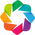

In [41]:

import pandas as pd
import numpy as np
import panel as pn
import holoviews as hv
hv.extension('bokeh')

def create_driver_timeline(timeline_data):
    df = pd.DataFrame(timeline_data)
    all_drivers = sorted(df['driver'].unique().tolist())
    driver_selector = pn.widgets.Select(name='Driver', options=all_drivers, width=200)    
    
    def create_year_panel(year_data):
        events_df = pd.DataFrame(year_data['events'])
        valid_pos_df = events_df.dropna(subset=['position'])
        valid_pos_df['short_round'] = valid_pos_df['round'].str.replace(' Grand Prix', '')        
        
        scatter_plot = valid_pos_df.hvplot.scatter(
            'short_round', 'position',
            title="Qualifying Performance",
            width=1000, 
            height=400,
            ylim=(20, 1),
            size=6,
            hover_cols=['round', 'gapToPole', 'teammateGap']
        ).opts(
            padding=0.1,
            show_grid=True,
            fontsize={'labels': 8, 'xticks': 8, 'yticks': 10, 'title': 14},
            xrotation=45,
            margin=(50,50,100,50),
            tools=['hover', 'pan', 'box_zoom', 'reset']
        )
        
        metrics = pn.Row(
            pn.pane.Markdown(f"Year: {year_data['year']}"),
            pn.pane.Markdown(f"Team: {year_data['team']}"),
            pn.pane.Markdown(f"Avg Qualifying: {year_data['avgQualifyingPosition']:.2f}"),
            pn.pane.Markdown(f"Avg Gap to Pole: {year_data['avgGapToPole']:.3f}s"),
            pn.pane.Markdown(f"vs Teammate: {year_data['avgTeammateGap']:.3f}s"),
            pn.pane.Markdown(f"Data Completeness: {year_data['dataCompleteness']*100:.0f}%")
        )        
        
        return pn.Column(
            metrics,
            pn.pane.HoloViews(scatter_plot, sizing_mode='stretch_width'),
            sizing_mode='stretch_width'
        )

    @pn.depends(driver_selector.param.value)
    def create_timeline(driver):
        if not driver:
            return pn.Column(pn.pane.Markdown("Please select a driver"))
            
        driver_data = df[df['driver'] == driver].sort_values('year')
        timeline_panels = [create_year_panel(year_data) for _, year_data in driver_data.iterrows()]
        
        return pn.Column(
            pn.pane.Markdown(f"# {driver}'s Qualifying Timeline"),
            *timeline_panels,
            sizing_mode='stretch_width'
        )    
    
    return pn.Column(
        pn.Row(driver_selector),
        pn.layout.Divider(),
        create_timeline,
        sizing_mode='stretch_width'
    )


In [42]:
dashboard = create_driver_timeline(career_timeline_data)

/var/folders/y0/lmjvhh9x73bbfknbrk6scl4h0000gn/T/ipykernel_61202/2967642250.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pos_df['short_round'] = valid_pos_df['round'].str.replace(' Grand Prix', '')


In [43]:
dashboard.show()


INFO:bokeh.server.server:Starting Bokeh server version 3.6.0 (running on Tornado 6.4.1)
INFO:bokeh.server.tornado:User authentication hooks NOT provided (default user enabled)


Launching server at http://localhost:59532


INFO:tornado.access:200 GET / (::1) 225.34ms
INFO:tornado.access:200 GET / (::1) 225.34ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/plotlyplot/mapbox-gl-js/v3.0.1/mapbox-gl.css?v=1.5.2 (::1) 10.42ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/plotlyplot/mapbox-gl-js/v3.0.1/mapbox-gl.css?v=1.5.2 (::1) 10.42ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/reactiveesm/es-module-shims@%5E1.10.0/dist/es-module-shims.min.js (::1) 32.11ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/reactiveesm/es-module-shims@%5E1.10.0/dist/es-module-shims.min.js (::1) 32.11ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/jquery/jquery.slim.min.js (::1) 34.02ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/jquery/jquery.slim.min.js (::1) 34.02ms
INFO:tornado.access:200 GET /static/extensions/panel/bundled/datatabulator/tabulator-tables@6.2.1/dist/js/tabulator.min.js (::1) 56.74ms
INFO:tornado.access:200 GET /stat